In [1]:
# MNIST test dataset
from tensorflow.keras.datasets import mnist

In [2]:
# import helper library
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import dataset
(trainx, trainy), (testx, testy) = mnist.load_data()

In [4]:
# seeing the shapes of imported dataset
trainx.shape, trainy.shape, testx.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

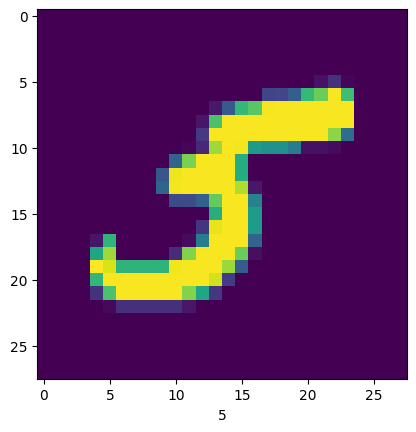

In [5]:
def choose_random_train():
    random_number = np.random.randint(0, 60000)
    sample_X = trainx[random_number]
    sample_y = trainy[random_number]
    return sample_X, sample_y, random_number

random_X, random_y, _ = choose_random_train()
plt.imshow(random_X)
plt.xlabel(random_y)

cursor = 0
def batch_generator_1000():
    global cursor
    print(cursor)
    x_batch = trainx[cursor:cursor+1000]
    y_batch = trainy[cursor:cursor+1000]
    cursor += 1000
    cursor %= 60000
    return x_batch, y_batch

# aax, aay = batch_generator_1000()
# aax.shape, aay.shape

### Making the layers

##### Layers
- Each layers maintains following associated datatypes:
    - Information types
        - name: Name of the layer
        - parameters_count: Number of parameters of the layer
    - Useful types
        - Depends on the type of layer:
            - Eg: For weights layer, it's the weight matrix
            - Eg: For bias layer, it's the bias vector
            - Eg: For the activation layer, it is nothing
        - They can be abstracted away for the user of the layer

- Each layer should have the following functions
    - Apply (input) -> output
        - It applies the layer's operation to it's input to give an output
    - Input gradient (output gradient, input value, output value) -> gradient values for input
        - It calculates the gradient for the input given the gradient values for the output.
        - It takes the output gradient values, it's input values and it's output values, if it saves the computations
    - Parameter gradient (output gradient, input value, output value) -> gradient values for parameters
        - It calculates the gradient for the parameters using the output gradients, input values and output values
        - If the layer doesn't have any parameters, it has to output zero (because we will sum the gradients, and we need something to sum it)
    - dummy gradient () -> a zero of shape of parameters
        - a zero gradient value of shape of the parameters
    - learn (parameter gradient, learning rate)
        - It modifies the parameter given the gradient of the parameters and the learning rate

In [6]:
# helper function
def expand_dims_and_transpose(x):
    return np.transpose(np.expand_dims(x, 0))
def expand_dims(x):
    return np.expand_dims(x, 0)

# layers
class Flattener:
    def __init__(self, shape):
        self.name = f"Flattener                 : {shape} to {np.prod(shape)}\n"
        self.param_count = 0

        self.from_shape = shape
    
    def apply(self, input_value):
        return np.ndarray.flatten(input_value)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return np.ndarray.reshape(output_gradient, self.from_shape)
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Weights:
    def __init__(self, input_size, output_size):
        self.name = f"Weights layer             : {input_size} to {output_size}"
        self.param_count = input_size * output_size
        
        # We create a transposed weights because input is a row vector
        self.weights = np.random.rand(input_size, output_size) - .5

    def apply(self, input_value):
        return np.matmul(input_value, self.weights)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        transposed_output_gradient = expand_dims_and_transpose(output_gradient)
        return np.transpose(np.matmul(self.weights, transposed_output_gradient))[0,:]
    
    def parameter_gradient(self, output_gradient, input_value, output_value=None):
        transposed_input = expand_dims_and_transpose(input_value)
        # print(np.shape(transposed_input), np.shape(output_gradient))
        return np.matmul(transposed_input, expand_dims(output_gradient))
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.weights))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.weights -= learning_rate * parameter_gradient_value

class Biases:
    def __init__(self, input_size):
        self.name = f"Biases layer              : {input_size}"
        self.param_count = input_size

        # We create a row vector of biases because input is a row vector
        self.biases = np.random.rand(input_size) - .5
    
    def apply(self, input_value):
        return input_value + self.biases
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.biases))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.biases -= learning_rate * parameter_gradient_value

class ReluActivation:
    def __init__(self):
        self.name = f"ReLU Activation\n"
        self.param_count = 0

        # we create a vectorized function for activaton
        self.activation_function = np.vectorize(lambda x: 0 if x < 0 else x)
        # similarly we create a vectorized function for gradient
        self.gradient_function = np.vectorize(lambda x: 0 if x < 0 else 1)
    
    def apply(self, input_value):
        return self.activation_function(input_value)
    
    def input_gradient(self, output_gradient, input_value, output_value=None):
        return np.multiply(output_gradient, self.gradient_function(input_value))
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class SoftmaxActivationOnlyWhenNeeded:
    def __init__(self, need=False):
        self.name = f"Softmax Activation, Activated:{need}\n"
        self.param_count = 0
        self.need = need
    
    def actual_apply(self, input_value):
        maximum = np.max(input_value)
        new_data = np.exp(input_value-maximum)
        denominator = np.sum(new_data)
        return new_data/denominator
        
    
    def apply(self, input_value):
        if self.need:
            return self.actual_apply(input_value)
        return input_value
    
    def actual_input_gradient(self, output_gradient, input_value, output_value=None):
        size = len(output_value)
        if output_value == None:
            output_value = self.actual_apply(input_value)
        magic_matrix = np.diag(output_value) - np.matmul(np.transpose(output_value), output_value)
        return np.matmul(output_gradient, magic_matrix)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        if self.need:
            return self.actual_input_gradient(output_gradient, input_value, output_value)
        return output_gradient
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

In [7]:
# dataset transformation
class OneHotEncoder:
    def __init__(self, input_size):
        self.name = "One hot encoder of size : {input_size}"
        self.size = input_size
    
    def __call__(self, number):
        output = np.zeros(self.size)
        output[number] = 1
        return output

class Identity:
    def __init__(self):
        self.name = "None"
    def __call__(self, x):
        return x

### Making the Loss Function
##### Loss function
- Each loss function has following data types
    - Name: Name of the loss function.

- Each loss function should implement the following methods
    - Apply(prediction, ground_truth) -> loss value
        - It calculates the required loss function.
    - Call(prediction, gournd_truth) -> loss value
        - It calls the apply function under the hood.
    - Prediction gradient(prediction, ground_truth) -> gradient values for output
        - It returns the gradient value for the loss wrt prediction value.
        - To calculate it, it is supplied with the prediction value and the ground truth.

In [8]:
def softmax_function(input_value):
    maximum = np.max(input_value)
    new_data = np.exp(input_value-maximum)
    denominator = np.sum(new_data)
    return new_data/denominator

class CrossEntropyLossFunctionFromLogits:
    def __init__(self):
        self.name = "Cross Entropy Loss Function from the logits"
        self.loss_function = softmax_function
    
    def apply(self, prediction, ground_truth):
        softmax_output = softmax_function(prediction)
        return np.sum(np.multiply(-ground_truth, np.log(prediction)))
    
    def __call__(self, prediction, ground_truth):
        return self.apply(prediction, ground_truth)
    
    def prediction_gradient(self, prediction, ground_truth):
        return np.sum(ground_truth)*softmax_function(prediction) - ground_truth


### Making the model
##### Sequential model
- Each sequential model should have following data types
    - Information types
        - Name: Name of the model
    - Useful types
        - Layers: A list of the sequential layers
        - Loss function : The function that defines the loss
        - Dataset transformation : The transformation that is applied to the output of the dataset

        - Cumulative parameter gradients for all layers
        - 
- Each sequential model should implement the following methods
    - Informational / debug
        - representation
    - Useful
        - inference (input) -> output
            - For simple inference
        - Reset gradient
            - To reset the parameter gradients for all layers
        - forward propagation (input) -> output
            - For simple layer by layer forward propagation
            - Saves the input to each layer
            - Saves the last output
            - Prepares for the back propagation
        - Back propagation (output gradients) ->
            - Layer by layer back propagation calculating the parameter gradients at each step, and back-propagating the intermediate gradients
            - Sums the parameter gradients
        - input gradients
            - To calculate the gradient of the input given the gradient of the output

    

In [9]:
class Sequential_Model:
    def __init__(self, layers, loss_function, name="Sequential Model",  dataset_transformation=Identity()):
        self.name = name

        self.layers = layers
        self.loss_function = loss_function
        self.dataset_transformation = dataset_transformation
        self.param_count = sum(layer.param_count for layer in layers)
        self.last_loss = 0
    
    def inference(self, input_value):
        last_output = input_value
        for layer in self.layers:
            last_output = layer.apply(last_output)
        return last_output

    def __call__(self, input_value):
        return self.inference(input_value)

    def reset_gradient(self):
        self.parameter_gradients = [layer.dummy_gradient() for layer in self.layers]
        self.last_loss = 0
    
    def forward_propagation(self, input_value):
        self.last_inputs = []

        last_input = input_value
        self.last_inputs.append(last_input)
        for layer in self.layers:
            last_input = layer.apply(last_input)
            self.last_inputs.append(last_input)
        return last_input
    
    def back_propagation(self, output_gradient):
        last_gradient = output_gradient
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            input_value = self.last_inputs[i]
            output_value = self.last_inputs[i+1]
            parameter_gradient = layer.parameter_gradient(last_gradient, input_value, output_value)

            # save cumulative gradients
            self.parameter_gradients[i] += parameter_gradient

            last_gradient = layer.input_gradient(last_gradient, input_value, output_value)
        return last_gradient
    
    def input_gradients(self, output_gradient):
        last = len(self.layers()) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            output_gradient = layer.input_gradient(output_gradient, self.last_inputs[i], self.last_inputs[i+1])
        return output_gradient
    
    def see_dataset_for_training(self, input_dataset, output_dataset):
        ground_truth = self.dataset_transformation(output_dataset)
        prediction = self.forward_propagation(input_dataset)
        prediction_gradient = self.loss_function.prediction_gradient(prediction, ground_truth)
        last_gradient = self.back_propagation(prediction_gradient)
        self.last_loss += self.loss_function(prediction, ground_truth)
        return last_gradient

    def make_model_learn(self, learning_rate):
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            layer.learn(self.parameter_gradients[i], learning_rate)
        pass

    def get_loss(self):
        return self.last_loss
    
    def __repr__(self):
        representation = f"{self.name}\n\n" 
        i = 0
        for layer in self.layers:
            i += 1
            representation += f"{i}. {layer.name}\n"
        representation += f"Total parameters = {self.param_count}\n"
        representation += f"Loss function = {self.loss_function.name}\n"
        return representation
        

        
            

In [10]:
# Building the model

MnistClassificationModel = Sequential_Model([
        Flattener(shape=(28,28)),
    
        Weights(28*28, 512),
        Biases(512),
        ReluActivation(),
    
        Weights(512, 200),
        Biases(200),
        ReluActivation(),
    
        Weights(200, 50),
        Biases(50),
        ReluActivation(),
    
        Weights(50, 10),
        Biases(10),
    
        SoftmaxActivationOnlyWhenNeeded(),
    ],
    loss_function=CrossEntropyLossFunctionFromLogits(),
    name="Simple MNIST handwritten digit dataset classifier",
    dataset_transformation=OneHotEncoder(10)
)
# Reset cursor for training dataset if model is reinstiated
cursor = 0

print(MnistClassificationModel)
# output = MnistClassificationModel(random_X)
# print(output)
# print(softmax_function(output))


Simple MNIST handwritten digit dataset classifier

1. Flattener                 : (28, 28) to 784

2. Weights layer             : 784 to 512
3. Biases layer              : 512
4. ReLU Activation

5. Weights layer             : 512 to 200
6. Biases layer              : 200
7. ReLU Activation

8. Weights layer             : 200 to 50
9. Biases layer              : 50
10. ReLU Activation

11. Weights layer             : 50 to 10
12. Biases layer              : 10
13. Softmax Activation, Activated:False

Total parameters = 515080
Loss function = Cross Entropy Loss Function from the logits



Simple MNIST handwritten digit dataset classifier

1. Flattener                 : (28, 28) to 784

2. Weights layer             : 784 to 512
3. Biases layer              : 512
4. ReLU Activation

5. Weights layer             : 512 to 200
6. Biases layer              : 200
7. ReLU Activation

8. Weights layer             : 200 to 50
9. Biases layer              : 50
10. ReLU Activation

11. Weights layer             : 50 to 10
12. Biases layer              : 10
13. Softmax Activation, Activated:False

Total parameters = 515080
Loss function = Cross Entropy Loss Function from the logits



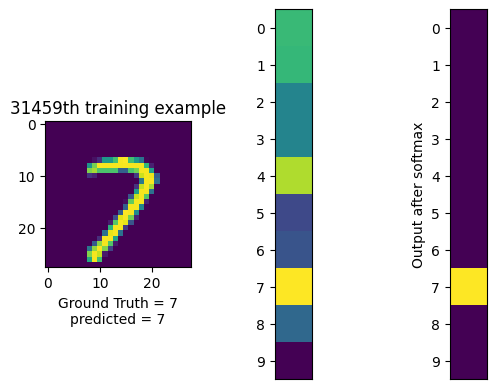

Logits output =  [  4013.17689249   3771.17015203   -735.56362573   -701.58845392
   8177.9463445   -5467.49548948  -4654.71391291  10674.54839605
  -3068.35585426 -10064.40217886]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Loss value for this example =  nan


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_58287/4081460434.py:14: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))
/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_58287/4081460434.py:14: RuntimeWarning: invalid value encountered in log
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))


In [13]:
def model_tester(print_outputs=False):
    rx, ry, n = choose_random_train()
    prediction = (MnistClassificationModel(rx))

    plt.subplot(1,3,1)
    plt.imshow(rx)
    plt.xlabel(f"Ground Truth = {ry}\npredicted = {np.argmax(prediction)}")
    plt.title(f"{n}th training example")

    plt.subplot(1,3,2)
    plt.imshow(np.reshape(prediction, (-1,1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(np.reshape(softmax_function(prediction), (-1, 1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    plt.ylabel("Output after softmax")

    plt.show()
    if print_outputs:
        print("Logits output = ", prediction)
        print("Softmax output = ", softmax_function(prediction))
        print("Loss value for this example = ", MnistClassificationModel.loss_function(prediction, ry))

print(MnistClassificationModel)
model_tester(True)


======= Epoch : 0 =======
Initial Loss = nan
40000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_58287/4081460434.py:14: RuntimeWarning: invalid value encountered in log
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))


Loss after training = nan


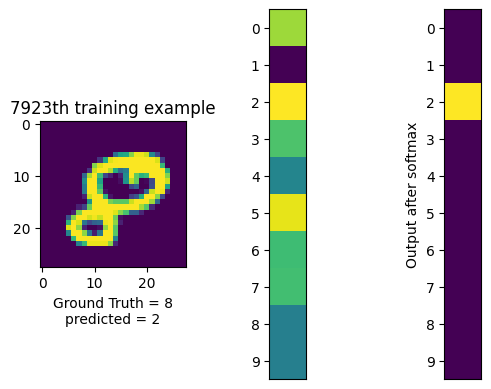

Logits output =  [  3935.29743034 -11801.53888748   6605.60748469   1485.81807814
  -3399.53139223   5929.59626678    877.00797008   1051.57744237
  -3834.68776583  -3876.90763266]
Softmax output =  [0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000
 0.00000000e+000 2.58260722e-294 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Loss value for this example =  nan

======= Epoch : 1 =======
Initial Loss = nan
41000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_58287/4081460434.py:14: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))


Loss after training = nan


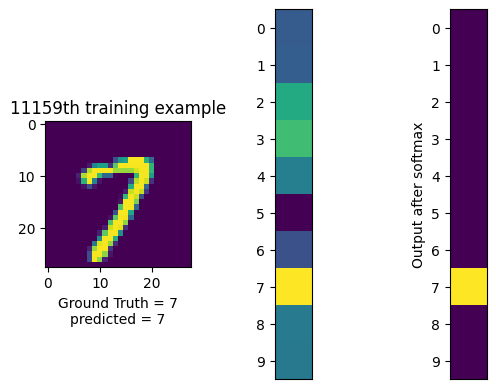

Logits output =  [-1.31761203e+03 -1.26136241e+03  2.03537099e+03  2.90118923e+03
  1.31061822e+02 -4.38197807e+03 -1.76810819e+03  6.10840453e+03
 -1.44638589e-01 -1.20301499e+02]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Loss value for this example =  nan

======= Epoch : 2 =======
Initial Loss = nan
42000
Loss after training = nan


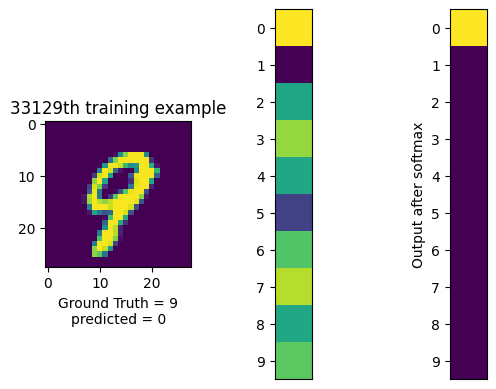

Logits output =  [ 1766.44181955 -4520.60529456  -834.06628121   773.05177289
  -785.26673757 -3285.74641792    69.81717111  1076.43197103
  -787.60296428   188.42066324]
Softmax output =  [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 2.15045484e-300
 0.00000000e+000 0.00000000e+000]
Loss value for this example =  nan

======= Epoch : 3 =======
Initial Loss = nan
43000
Loss after training = nan


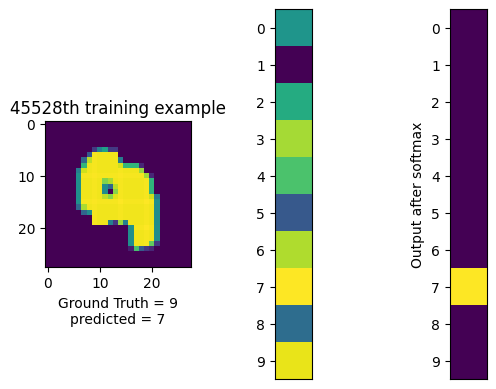

Logits output =  [-1728.39922171 -5756.84097287 -1009.13028115   905.85872857
  -220.54353553 -3596.89117243  1034.71509405  1947.32749183
 -3002.28341113  1697.43771003]
Softmax output =  [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
 0.00000000e+000 2.98020872e-109]
Loss value for this example =  nan

======= Epoch : 4 =======
Initial Loss = nan
44000
Loss after training = nan


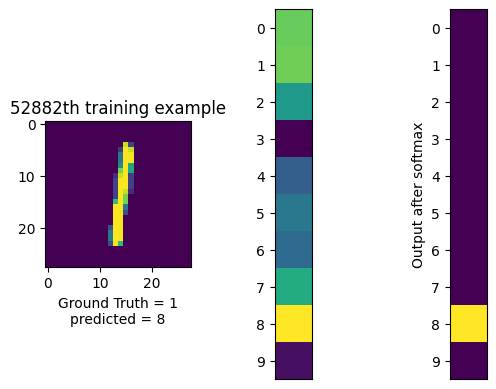

Logits output =  [ 2989.09271703  3123.34650624  1078.4841227  -3455.91558213
  -893.26002326  -103.1357991   -521.9567562   1722.44089089
  4957.24487751 -3096.72617838]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Loss value for this example =  nan

======= Epoch : 5 =======
Initial Loss = nan
45000
Loss after training = nan


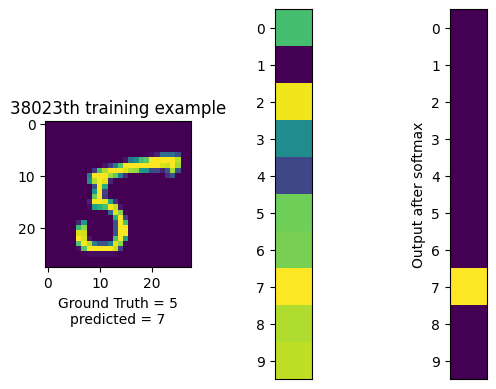

Logits output =  [-1434.73477381 -8309.97272261  1232.81684533 -3580.20594027
 -6238.53672928  -708.22799095  -540.935634    1441.89564156
   285.72526051   517.24184829]
Softmax output =  [0.00000000e+00 0.00000000e+00 1.57845613e-91 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00]
Loss value for this example =  nan

======= Epoch : 6 =======
Initial Loss = nan
46000
Loss after training = nan


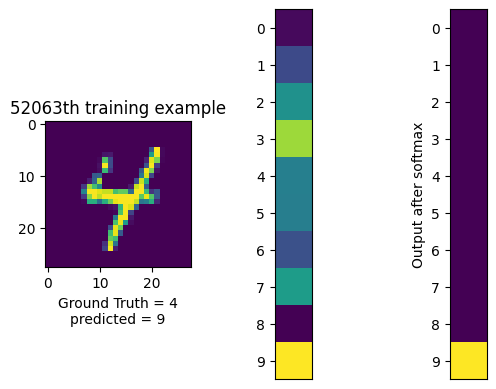

Logits output =  [-4538.16075392 -2401.36541815   550.80342691  4241.55809106
  -232.37711259  -281.29476078 -2160.65229481  1078.27323769
 -4806.26005067  5809.82135169]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Loss value for this example =  nan

======= Epoch : 7 =======
Initial Loss = nan
47000
Loss after training = nan


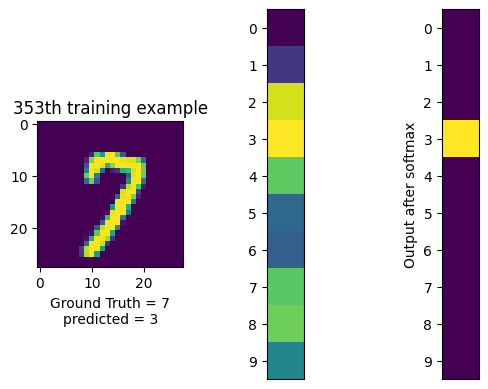

Logits output =  [-5950.77987824 -4459.29297743  2822.36492218  3410.10001664
  1076.28031386 -2745.65378973 -3163.81819205  1020.42664716
  1352.88104582 -1662.80839378]
Softmax output =  [0.00000000e+000 0.00000000e+000 5.62201051e-256 1.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Loss value for this example =  nan

======= Epoch : 8 =======
Initial Loss = nan
48000
Loss after training = nan


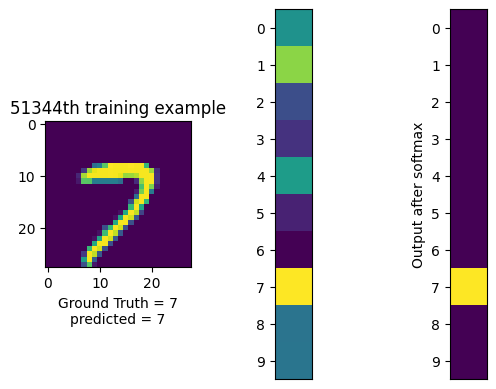

Logits output =  [  462.86640539  6295.42781583 -4515.51717364 -6214.12883796
  1240.44208269 -7129.98706883 -8929.3095857   9505.73729435
 -1815.57133273 -1796.22269865]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Loss value for this example =  nan

======= Epoch : 9 =======
Initial Loss = nan
49000
Loss after training = nan


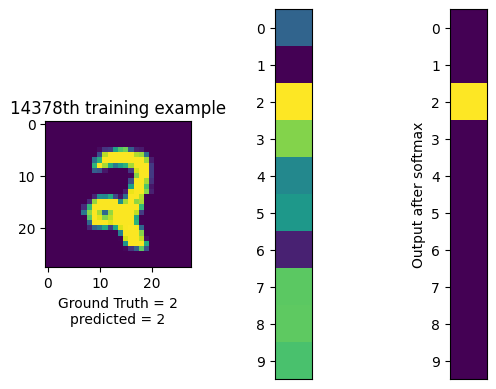

Logits output =  [-1742.18336018 -3843.3133355   2642.53165717  1448.89263821
  -824.13454445  -388.70137654 -3238.72060698  1010.3511972
  1045.28190745   769.76479757]
Softmax output =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 10 =======
Initial Loss = nan
50000
Loss after training = nan


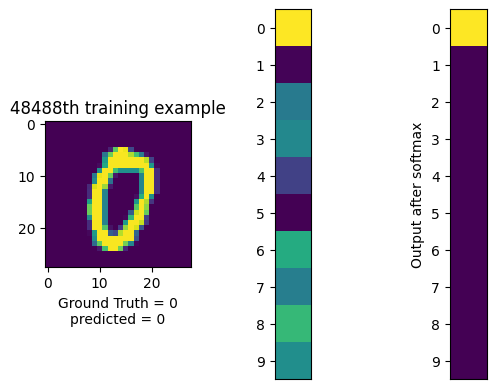

Logits output =  [ 5164.43567097 -7446.13417805 -2340.91519255 -1626.53102291
 -5091.27649875 -7556.26179308   259.30061473 -2132.56938785
   946.80404007 -1266.72829851]
Softmax output =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 11 =======
Initial Loss = nan
51000
Loss after training = nan


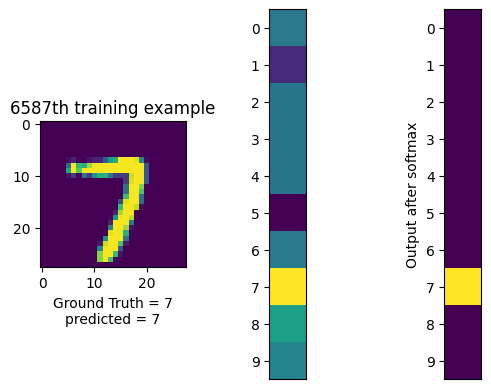

Logits output =  [ -830.45314529 -4216.02784008  -971.55380882  -985.42107541
  -992.25282423 -5693.77768069  -763.89865214  6423.23858225
  1165.46234953  -238.44513362]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Loss value for this example =  nan

======= Epoch : 12 =======
Initial Loss = nan
52000
Loss after training = nan


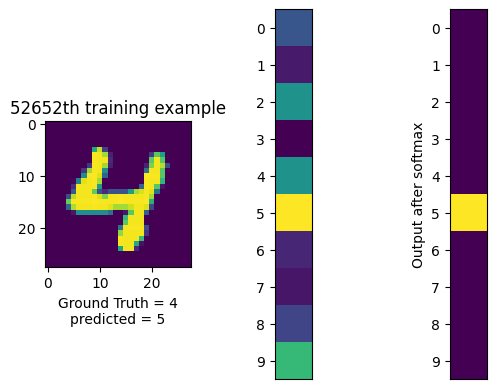

Logits output =  [-2095.7698017  -3938.46008651   276.09051668 -4629.16711902
   264.89403072  4906.29527478 -3596.3789896  -4051.98775622
 -2652.63484827  1750.13254898]
Softmax output =  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 13 =======
Initial Loss = nan
53000
Loss after training = nan


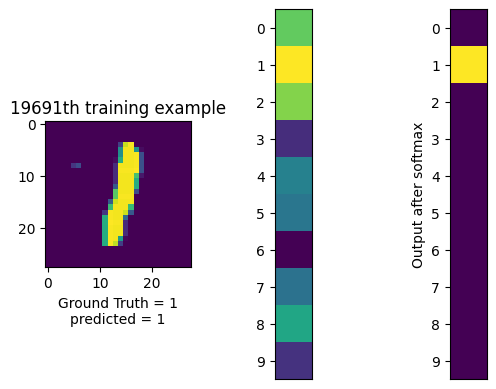

Logits output =  [ 2737.55657029  5199.5410527   3276.11669124 -3743.83061187
  -579.23362179 -1050.04260309 -5092.2058106  -1197.13360519
   979.55220907 -3564.86478259]
Softmax output =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 14 =======
Initial Loss = nan
54000
Loss after training = nan


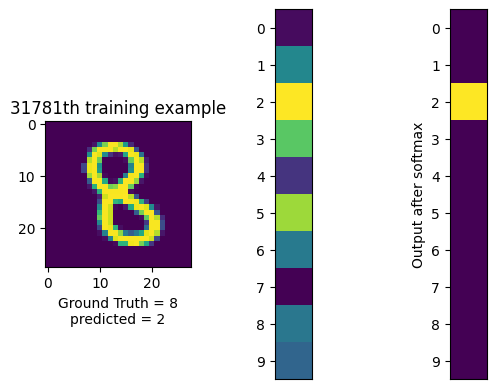

Logits output =  [-7124.93619309 -1235.56613093  6089.97791218  2618.91094228
 -5471.44771798  4102.42544651 -1938.98174092 -7526.55352491
 -2129.51095686 -3065.09576191]
Softmax output =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 15 =======
Initial Loss = nan
55000
Loss after training = nan


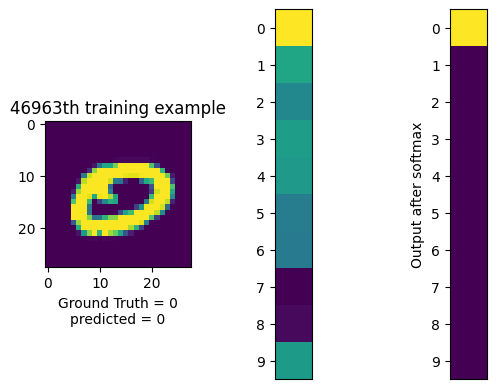

Logits output =  [ 9986.50983189  4029.12876132  2280.56691718  3611.26858964
  3299.52902999  1578.77247693  1499.99990023 -4482.26510141
 -4089.725694    3415.09475742]
Softmax output =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 16 =======
Initial Loss = nan
56000
Loss after training = nan


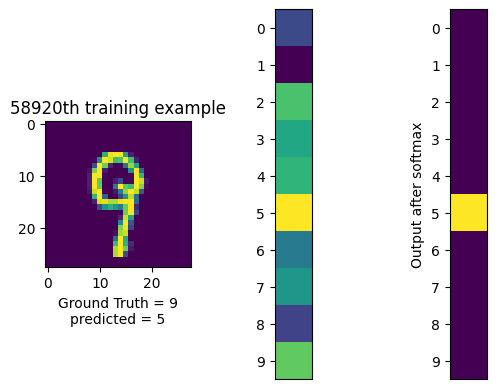

Logits output =  [-3551.55895914 -5162.63330084   -36.13203737  -836.64021047
  -445.04580378  2034.49477307 -2223.8428991  -1340.17984947
 -3727.53380728   269.72532635]
Softmax output =  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 17 =======
Initial Loss = nan
57000
Loss after training = nan


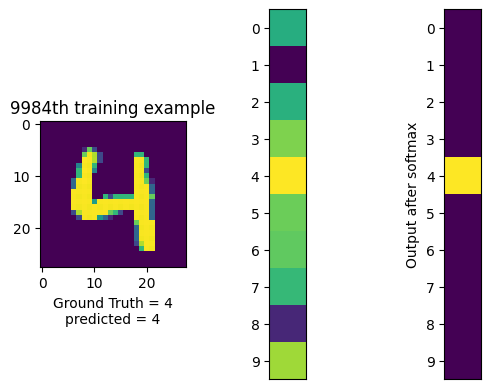

Logits output =  [ -2496.76192247 -12815.41285839  -2300.33754474    570.37037768
   3751.34723455     19.88472387   -279.22021836  -1702.28173084
 -10956.60976702   1361.43618448]
Softmax output =  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 18 =======
Initial Loss = nan
58000
Loss after training = nan


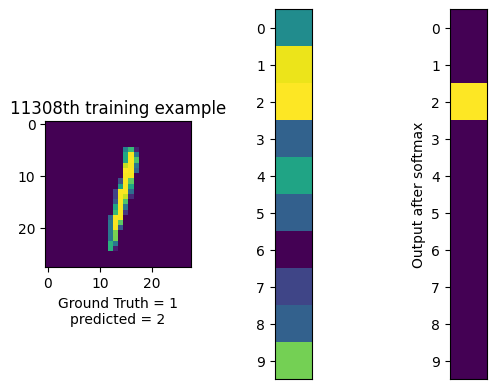

Logits output =  [ -349.16089792  4660.0253887   4951.69738462 -2117.69324179
   640.96447239 -2221.98539307 -5373.53079243 -3222.24452489
 -2162.85675848  2796.57519843]
Softmax output =  [0.00000000e+000 2.13040243e-127 1.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Loss value for this example =  nan

======= Epoch : 19 =======
Initial Loss = nan
59000
Loss after training = nan


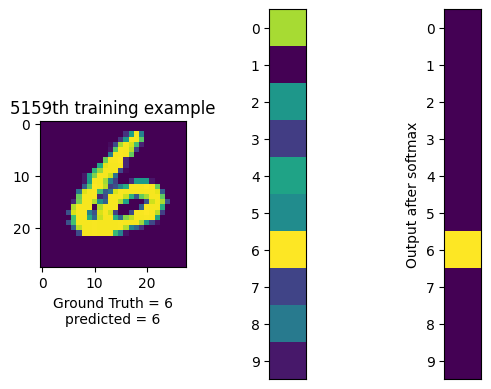

Logits output =  [ 7428.22648152 -7448.90244636  1635.11825984 -4368.1330868
  2481.91241591   880.91232187  9688.78920281 -3958.65948972
  -360.44147049 -6375.64665328]
Softmax output =  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Loss value for this example =  nan


In [19]:
epochs = 20
learning_rate = 0.00001
for epoch in range(epochs):
    print(f"\n======= Epoch : {epoch} =======")
    print(f"Initial Loss = {MnistClassificationModel.get_loss()}")
    MnistClassificationModel.reset_gradient()
    batchx, batchy = batch_generator_1000()
    for tx, ty in zip(batchx, batchy):
        MnistClassificationModel.see_dataset_for_training(tx, ty)
    MnistClassificationModel.make_model_learn(learning_rate/1000)
    print(f"Loss after training = {MnistClassificationModel.get_loss()}")
    model_tester(print_outputs=True)


array([[-3060.33741322],
       [-6110.33010061],
       [ 6994.61478336],
       [ -938.07447702],
       [ -106.1292806 ],
       [ 5890.8362855 ],
       [-4934.4322498 ],
       [-1253.9065183 ],
       [ 1257.39195773],
       [-1541.68907417]])

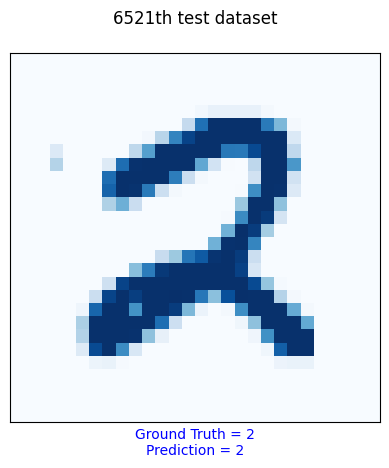

In [17]:
def choose_random_test():
    limit = len(testy)
    random_number = np.random.randint(0, limit)
    sample_X = testx[random_number]
    sample_y = testy[random_number]
    return sample_X, sample_y, random_number
    
def choose_random_and_test_model(log_output=True):
    xx, yy, n = choose_random_test()
    prediction = MnistClassificationModel(xx)
    prediction_number = np.argmax(prediction)

    correct = prediction_number == yy
    colour = 'blue' if correct else 'red'
    plt.imshow(xx, cmap="Blues")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Ground Truth = {yy}\nPrediction = {prediction_number}", color=colour)
    plt.title(f"{n}th test dataset\n")
    return np.reshape(prediction, (-1,1))
    
choose_random_and_test_model() 

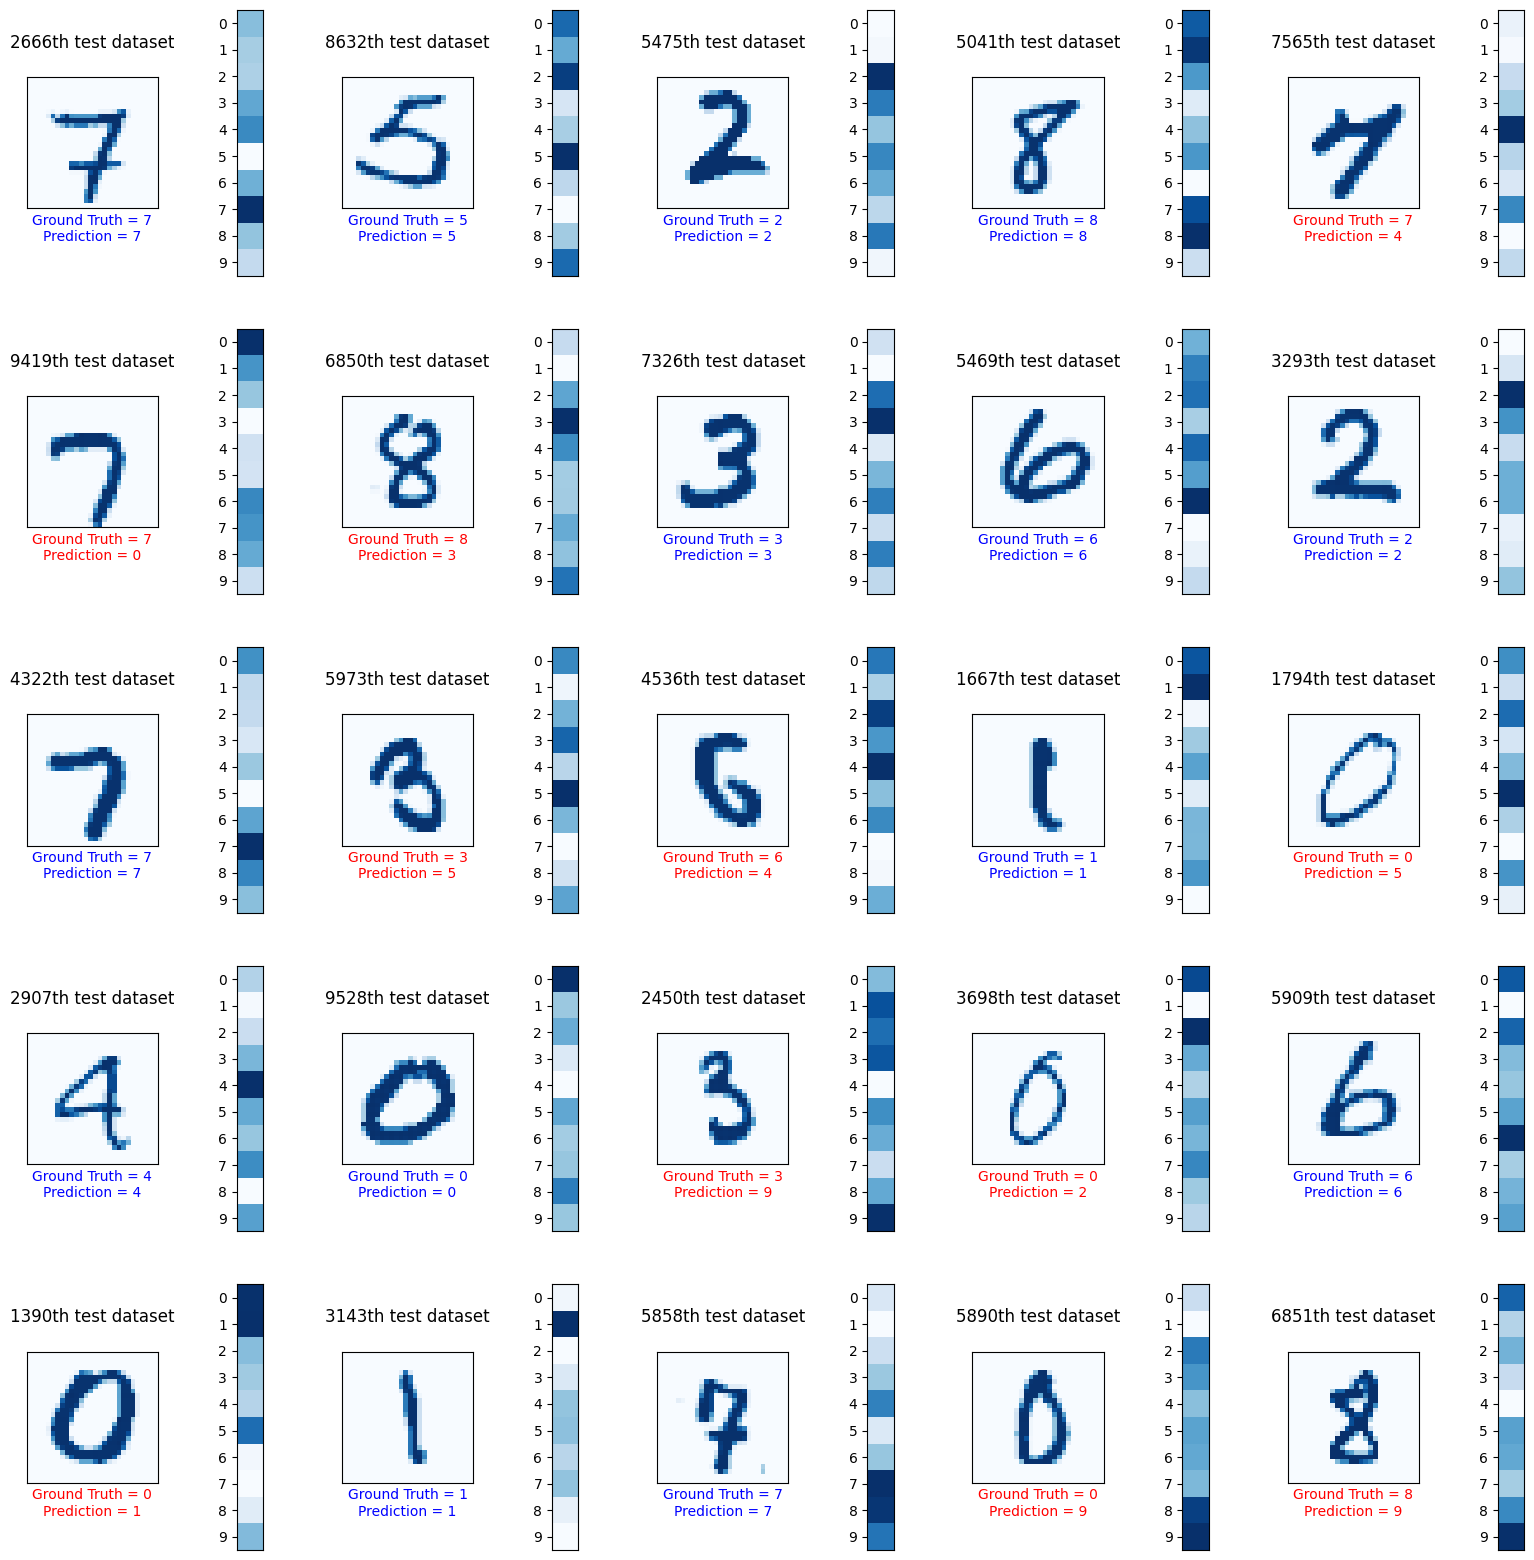

In [20]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,10, i*2+1)
    prediction = choose_random_and_test_model()

    plt.subplot(5, 10, i*2+2)
    plt.imshow(prediction, cmap='Blues')
    plt.yticks(np.arange(10))
    plt.xticks([])

plt.savefig("Output.png")
    